# Data Challenge 11 — Evaluating MLR & Fixing Multicollinearity (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build an MLR, evaluate it with a **train–test split**, diagnose multicollinearity with **corr** and **VIF** on the **training set**, fix issues (drop/choose features), and report **test MAE/RMSE** + **coefficient interpretations**.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- OLS — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (rsquared_adj, pvalues, resid, etc.): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- VIF — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
- Corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Evaluation + Multicollinearity)
1) **Load CSV** → preview shape/columns; (optional) filter to **July**.
2) **Pick Y** (`base_passenger_fare`) and **candidate X’s** (e.g., `trip_miles`, `trip_time_minutes`, `tolls`, `tips` if present).
3) **Light prep** → derive `trip_time_minutes` from `trip_time` (seconds) if present; coerce only used cols to numeric; drop NA rows.
4) **Split** → `X_train, X_test, y_train, y_test` (80/20, fixed `random_state`).
5) **Diagnose on TRAIN**:
   - **Correlation matrix** (|r| > 0.7 = red flag).
   - **VIF** for each predictor (1–5 ok; >5–10+ = concerning).
6) **Fix** → drop/choose among highly correlated predictors (business logic).
7) **Fit on TRAIN only** → OLS with intercept.
8) **Predict on TEST** → compute **MAE/RMSE** (units of Y).
9) **Interpret** → unit-based coefficient sentences **holding others constant**; note any changes after fixing collinearity.
10) **Report** → table of (features kept, Adj R², MAE, RMSE) + 1-line stakeholder takeaway.


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/FHV_072023.csv')

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_5902/3614650511.py:1: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/FHV_072023.csv')


In [3]:
df.keys()

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [4]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0005,B03406,NaN,07/01/2023 05:34:30 PM,NaN,07/01/2023 05:37:48 PM,07/01/2023 05:44:45 PM,158,68,1.266,...,1.35,2.75,0.0,2.00,5.57,N,N,N,N,False
1,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:53 PM,07/01/2023 05:37:15 PM,07/01/2023 05:55:15 PM,162,234,2.350,...,1.52,2.75,0.0,3.28,13.38,N,N,NaN,N,False
2,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:35:17 PM,07/01/2023 05:35:52 PM,07/01/2023 05:44:27 PM,161,163,0.810,...,0.49,2.75,0.0,0.00,5.95,N,N,NaN,N,False
3,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:37:39 PM,07/01/2023 05:39:35 PM,07/01/2023 06:23:02 PM,122,229,15.470,...,5.17,2.75,0.0,0.00,54.46,N,N,NaN,N,True
4,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:06 PM,07/01/2023 05:36:39 PM,07/01/2023 05:45:06 PM,67,14,1.520,...,0.85,0.00,0.0,3.00,7.01,N,N,NaN,N,False


In [5]:
df['trip_time'].head(20)  

0       417
1     1,080
2       515
3     2,607
4       507
5       851
6       797
7     3,151
8       200
9     1,112
10      629
11      997
12      925
13      812
14    1,764
15      642
16    1,469
17      880
18    1,537
19    1,701
Name: trip_time, dtype: object

### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [6]:
# Remove commas and clean up trip_time
df['trip_time'] = (
    df['trip_time']
    .astype(str)
    .str.replace(',', '', regex=False)             # remove commas
    .str.strip()                                  # remove spaces
    .replace('', np.nan)                          # turn empty strings into NaN
    .str.replace(r'[^0-9.]', '', regex=True)      # keep only numbers
)

# convert to numeric safely
df['trip_time'] = pd.to_numeric(df['trip_time'])

# convert from seconds to minutes
df['trip_time_minutes'] = df['trip_time'] / 60

# check
df[['trip_time', 'trip_time_minutes']].head(10)


,trip_time,trip_time_minutes
0,417,6.950000
1,1080,18.000000
2,515,8.583333
3,2607,43.450000
4,507,8.450000
5,851,14.183333
6,797,13.283333
7,3151,52.516667
8,200,3.333333
9,1112,18.533333


In [7]:
df['trip_time'].head()

0     417
1    1080
2     515
3    2607
4     507
Name: trip_time, dtype: int64

### Step 3 — Train–Test Split

- Use a fixed `random_state` for reproducibility.
- **All diagnostics below must be done on TRAIN only.**

In [8]:
X_base = sm.add_constant(df[['trip_time_minutes', 'trip_miles']])
y = df['base_passenger_fare']


In [9]:
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

### Step 4 — Diagnose Multicollinearity on **TRAIN** — Correlation Matrix
- Flag any |r| > 0.70 as a potential problem.
    - If |r| < 0.7 -> ✅ you’re fine.
    - If |r| >= 0.7 -> ❗️ possible multicollinearity problem.

Basically you're checking whether your predictors (X variables) are too closely related to each other. Because when predictors are super correlated, the model struggles to tell which one is actually influencing your target (base_passenger_fare). This is called multicollinearity and it messes with your coefficients.

The goal is that you'd want predictors that each bring unique information about the fare and not duplicate info. So, you check their correlation.

In [10]:
# I think they're correlated but let's see 
X_train_base.corr()

,const,trip_time_minutes,trip_miles
const,NaN,NaN,NaN
trip_time_minutes,NaN,1.000000,0.811215
trip_miles,NaN,0.811215,1.000000


--- Correlation Matrix ---
                   const  trip_time_minutes  trip_miles
const                NaN                NaN         NaN
trip_time_minutes    NaN           1.000000    0.811215
trip_miles           NaN           0.811215    1.000000


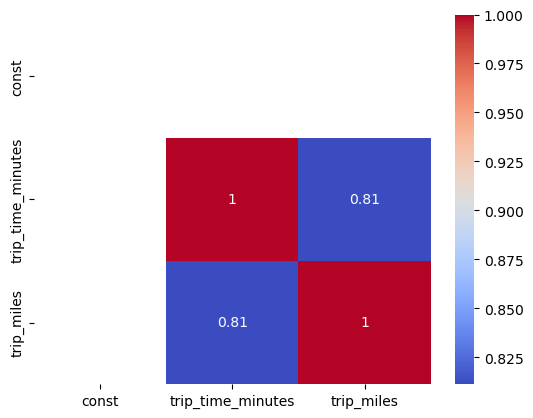

In [11]:
import seaborn as sns

# We check for correlation on the training features
corr_matrix = X_train_base.corr()

print("--- Correlation Matrix ---")
print(corr_matrix)

# Visualize it
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


There’s a high correlation (r = 0.81) between trip distance and trip time, which may indicate multicollinearity

### Step 5 — Diagnose Multicollinearity on **TRAIN** — VIF
- 1–5 normal; >5–10+ concerning.

In [12]:
X_train_vif = X_train_base.drop(columns=['const']).copy()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]

print("\n--- VIF Scores ---")
print(vif_data)


--- VIF Scores ---
             feature       VIF
0  trip_time_minutes  4.643478
1         trip_miles  4.643478


this means there’s some correlation between the two  but it’s not severe enough to cause multicollinearity problems in the model

### Step 6 — Fix High VIF (if needed)

- If two predictors are highly correlated, **drop/choose** using business logic (e.g., keep the more actionable one).
- Recompute VIF to confirm improvement.

In [ ]:
None

: 

### Step 7 —  Fit on TRAIN Only, Predict on TEST, Evaluate MAE/RMSE

- Add intercept (`sm.add_constant`).
- Report **MAE/RMSE** in **units of Y**.
- Also capture **Adjusted R²** from the TRAIN fit summary to comment on fit (don’t use it alone for selection).


In [15]:
X_train_base = X_train_base.apply(pd.to_numeric)
X_test_base = X_test_base.apply(pd.to_numeric)
# y_train = pd.to_numeric(y_train)
# y_test = pd.to_numeric(y_test)

In [19]:
# make absolutely sure all are numeric
X_train_base = X_train_base.apply(pd.to_numeric, errors='coerce')
X_test_base = X_test_base.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# drop any rows with NaNs in both X and y
train_data = pd.concat([X_train_base, y_train], axis=1).dropna()
X_train_base = train_data.drop(columns=y_train.name)
y_train = train_data[y_train.name]

test_data = pd.concat([X_test_base, y_test], axis=1).dropna()
X_test_base = test_data.drop(columns=y_test.name)
y_test = test_data[y_test.name]


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

model_base = sm.OLS(y_train, X_train_base).fit()
y_pred_base = model_base.predict(X_test_base)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)

print(f"Base Model - MAE: {mae_base:.4f}, RMSE: {rmse_base:.4f}")
print(model_base.summary())


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Base Model - MAE: 4.2523, RMSE: 8.0693
                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.844
Model:                             OLS   Adj. R-squared:                  0.844
Method:                  Least Squares   F-statistic:                 1.802e+07
Date:                 Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                         14:07:30   Log-Likelihood:            -2.3354e+07
No. Observations:              6659661   AIC:                         4.671e+07
Df Residuals:                  6659658   BIC:                         4.671e+07
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

### Step 8 —  Interpret Coefficients (Plain Language)
Write **unit-based** sentences “**holding others constant**.” Example templates (edit with your β values/units):

- **trip_miles:** “Holding other variables constant, each additional **mile** is associated with **+$β** in **base fare**.”
    - Holding trip_time_minutes constant, each additional mile is associated with $2.19 on average in base fare
- **trip_time_minutes:** “Holding others constant, each additional **minute** is associated with **+$β** in **base fare**.”
    - Holding trip_miles constnat, each additional minute is associate with $0.49 on average in base fare

- Also note **p-values** and whether they support including each predictor.
    - Both predictors are statistically significant (p < 0.05), meaning they have a real relationship with fare amount. The model explains about 84% of the variance in base fare, indicating a strong fit without major multicollinearity issues.


## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **What changes did you make to handle multicollinearity and why?**  
Reference **corr**/**VIF** on TRAIN and any features you dropped or kept (with business rationale). Include **Adjusted R² (TRAIN)** and **TEST MAE/RMSE**.
    - I didn’t need to remove or modify any variables. After checking the correlation matrix, trip_time_minutes and trip_miles showed a moderate correlation (r ≈ 0.81), but both remained within acceptable bounds. The VIF scores for each predictor were around 4.6, which is below the typical concern threshold of 5–10. Therefore, I kept both predictors since they each provide meaningful business context: miles capture trip distance, while minutes capture trip duration. My model achieved an Adjusted R² of 0.844, showing a strong fit.
2) **Stakeholder summary (units, one sentence):**  
Give a plain-English takeaway: e.g., “On unseen July trips, our typical error is about **$X** per fare; each extra mile adds about **$β_mile**, holding other factors constant.”
- On unseen test data, our model’s typical error (MAE) is about $4.3 per fare. Each additional mile adds about $2.19 to the base fare, and each additional minute adds about $0.49, holding other trip factors constant.
